## `rscd` step

For MIRI multiple integration data, the reset switch decay causes the the initial groups in integrations after the first one to be offset from their expected linear accumulation of signal. The most significant deviations occur in groups 1 and 2. This step corrects for these effects.

Official documentation for `rscd` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html>


### Input data

An example of running the `rscd` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public), with precending pipeline steps applied, i.e. `linearity` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `rscd` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print(rscd_step.RSCD_Step.__doc__)
print(rscd_step.RSCD_Step.spec)



    RSCD_Step: Performs an RSCD correction to MIRI data.
    Baseline version flags the first N groups as 'DO_NOT_USE' in
    the 2nd and later integrations in a copy of the input
    science data model.
    Enhanced version is not ready nor enabled.
    

         type = option('baseline','enhanced',default = 'baseline') # Type of correction
       


Set the name of the input file and run the step. This will produce an output file ending with `_rscd_step.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `rscd` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits'

# run the step
dm = rscd_step.RSCD_Step.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 14:07:39,118 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'
2020-10-29 14:07:39,120 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2020-10-29 14:07:39,203 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits',).
2020-10-29 14:07:39,205 - stpipe.RSCD_Step - INFO - Step RSCD_Step parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}
2020-10-29 14:07:39,524 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0010.fits
2020-10-29 14:07:41,887 - stpipe.RSCD_Step - INFO - Saved model in det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits
2020-

Since `rscd` only applies a correction to integrations >1, we can check one of these to see the correction. If there is only one integration, then `rscd` doesn't do anything.

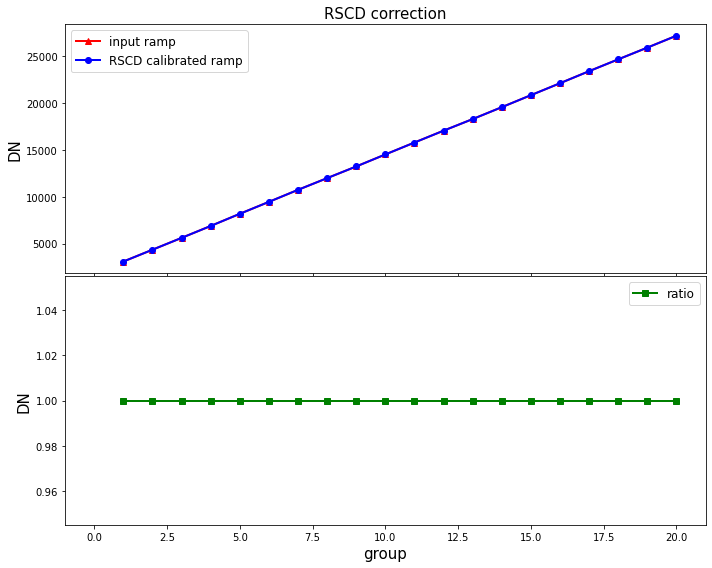

In [4]:
# set the sample pixel
pixel = [600,500]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# open the input file as a datamodel
in_dm = datamodels.open(my_input_file)

# first check that there is more than one integration
if dm.data.shape[0] > 1:

    # plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
                linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', 
                linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], c='g', 
                marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: 
    print("RSCD step only operates on exposures with more than one integration.")



### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `RSCD_Step` class using the `strun` command:

```bash
strun jwst.rscd.RSCD_Step det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `RSCD_Step` using the `strun` command with the associated `rscd.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/rscd.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits
```

This will produce the same output file ending with `_rscd_step.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.rscd.RSCD_Step -h
```

or 

```bash
strun cfgs/rscd.cfg -h
```


### Override reference file

To override the reference file for this step in Python:

```python
# set the override reference file name
my_ref = 'my_rscd.fits'

dm = rscd.RSCD_Step.call(my_input_file, output_use_model=True, save_results=True, 
                         override_rscd=my_ref)
```

and using the command line:

```bash
strun jwst.rscd.RSCD_Step det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits  --override_rscd my_rscd.fits
```

or

```bash
strun cfgs/rscd.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits --override_rscd my_rscd.fits
```